In [1]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import seaborn as sns
from scipy.stats import kruskal
from scipy.stats import spearmanr
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter


,Exp_ID,Image_Metadata_Site,track_id,Image_Metadata_T,Nuclear_size,ERKKTR_ratio,FoxO3A_ratio,objNuclei_Location_Center_X,objNuclei_Location_Center_Y
0,1,1,1,0,303.000,0.704407,1.33383,932.211,875.248
1,1,1,1,1,333.000,0.848242,1.33791,932.150,874.174
2,1,1,1,2,314.000,1.059170,1.37627,932.376,873.787
3,1,1,1,3,322.000,1.188000,1.35754,932.168,873.453
4,1,1,1,4,313.999,1.205540,1.36695,931.146,872.885


In [17]:
file=pd.read_csv("C:\\Users\\Anastazja\\Downloads\\single-cell-tracks_exp1-6.csv.gz",compression='gzip')
file.head()

,Exp_ID,Image_Metadata_Site,track_id,Image_Metadata_T,Nuclear_size,ERKKTR_ratio,FoxO3A_ratio,objNuclei_Location_Center_X,objNuclei_Location_Center_Y
0,1,1,1,0,303.000,0.704407,1.33383,932.211,875.248
1,1,1,1,1,333.000,0.848242,1.33791,932.150,874.174
2,1,1,1,2,314.000,1.059170,1.37627,932.376,873.787
3,1,1,1,3,322.000,1.188000,1.35754,932.168,873.453
4,1,1,1,4,313.999,1.205540,1.36695,931.146,872.885


In [53]:
import gc
gc.collect()

5345

In [2]:
# dictionary of mutations and corresponding Image_Metadata_Site
site_map = {
    'wt': [1, 2, 3, 4],
    'akt1': [5, 6, 7, 8],
    'pik_545': [9, 10, 11, 12],
    'pik_1047': [13, 14, 15, 16],
    'pten': [17, 18, 19, 20, 21, 22, 23, 24],
}

# Reverse mapping: nb site → mutation
site_to_mutation = {}

for mutation, site_list in site_map.items():
    for site in site_list:
        site_to_mutation[site] = mutation

file['Mutation'] = file['Image_Metadata_Site'].map(site_to_mutation)


## Comparison of signaling pathway activity between mutations

### Signal dynamics over time

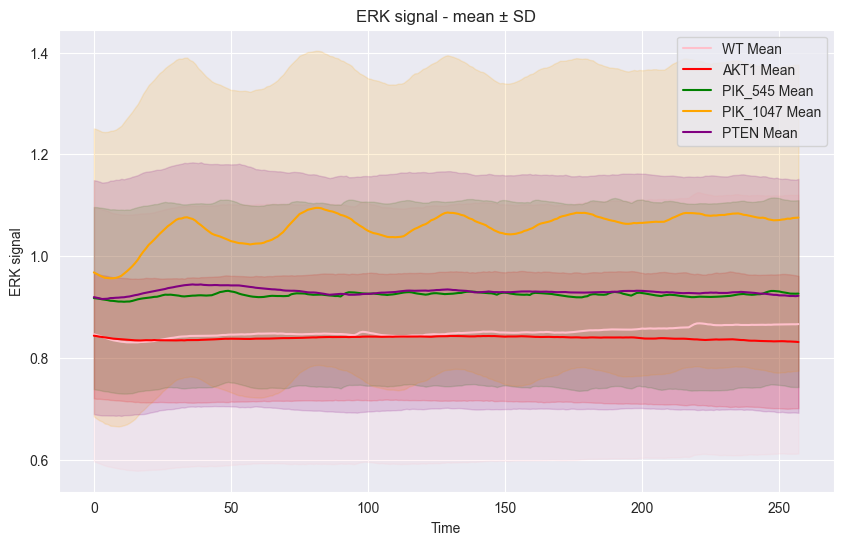

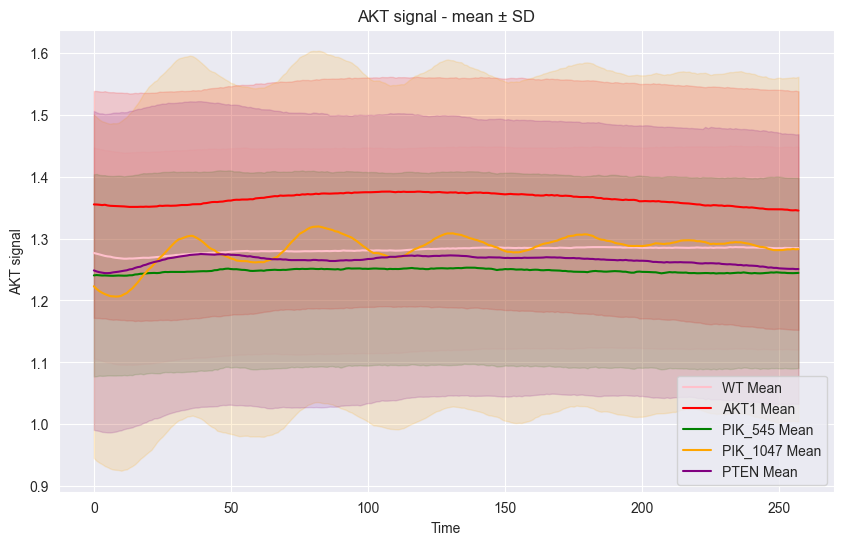

In [78]:
# Extracting data based on the map
data_dict = {key: file[file['Image_Metadata_Site'].isin(sites)] for key, sites in site_map.items()}

# Time frame
time = np.arange(0, 258, 1)
signal = pd.DataFrame(time, columns=['time'])

# Means and standard deviations
mean_erk = {}
std_erk = {}
mean_akt = {}
std_akt = {}

for key, df in data_dict.items():
    grouped_erk = df.groupby('Image_Metadata_T')['ERKKTR_ratio']
    grouped_akt = df.groupby('Image_Metadata_T')['FoxO3A_ratio']

    mean_erk[key] = grouped_erk.mean()
    std_erk[key] = grouped_erk.std()

    mean_akt[key] = grouped_akt.mean()
    std_akt[key] = grouped_akt.std()

# Colors for mutations
colors = {
    'wt': 'pink',
    'akt1': 'red',
    'pik_545': 'green',
    'pik_1047': 'orange',
    'pten': 'purple'
}

# Function for plotting the mean signal pathway and SD
def plot_signal_pathway(mean_signal, std_signal, signal_type):

    plt.figure(figsize=(10, 6))

    for key in site_map:
        plt.plot(time, mean_signal[key], label=f'{key.upper()} Mean', color=colors.get(key, 'grey'))
        plt.fill_between(
            time,
            mean_signal[key] - std_signal[key],
            mean_signal[key] + std_signal[key],
            color=colors.get(key, 'grey'),
            alpha=0.15,
        )

    plt.xlabel('Time')
    plt.ylabel(f'{signal_type} signal')
    plt.title(f'{signal_type} signal - mean ± SD')
    plt.legend()
    plt.show()


plot_signal_pathway(mean_erk, std_erk, 'ERK')
plot_signal_pathway(mean_akt, std_akt, 'AKT')


### Statistical tests: WT activity versus mutation activity


In [81]:

time_range = (12, 36)

# Dictionaries for results
erk_results = {}
akt_results = {}

# Loop over all mutations
for key, sites in site_map.items():
    df = file[file['Image_Metadata_Site'].isin(sites)]
    filtered = df[(df['Image_Metadata_T'] >= time_range[0]) & (df['Image_Metadata_T'] <= time_range[1])]
     # Calculating the means
    erk_results[key] = filtered.groupby('Image_Metadata_T')['ERKKTR_ratio'].mean()
    akt_results[key] = filtered.groupby('Image_Metadata_T')['FoxO3A_ratio'].mean()


test_results = []

# Mann-Whitney test for pairs (WT, mutation)

for mutation in site_map.keys():
    if mutation == 'wt':continue
    # ERK
    stat_erk, p_value_erk = mannwhitneyu(list(erk_results['wt']), list(erk_results[mutation]) , alternative='two-sided')

    # AKT
    stat_akt, p_value_akt = mannwhitneyu(list(akt_results['wt']), list(akt_results[mutation]), alternative='two-sided')

    # Save results
    test_results.append({
        'Mutation': mutation,
        'Statistic_ERK': stat_erk,
        'P_value_ERK': p_value_erk,
        'Bonferroni_ERK': None,
        'Statistic_AKT': stat_akt,
        'P_value_AKT': p_value_akt,
        'Bonferroni_AKT': None
    })

# Bonferroni correction for multiple comparisons
pvals = [r['P_value_ERK'] for r in test_results]
_, pvals_corr, _, _ = multipletests(pvals, method='bonferroni')
for i, p_corr in enumerate(pvals_corr):
    test_results[i]['Bonferroni_ERK'] = p_corr

pvals = [r['P_value_AKT'] for r in test_results]
_, pvals_corr, _, _ = multipletests(pvals, method='bonferroni')
for i, p_corr in enumerate(pvals_corr):
    test_results[i]['Bonferroni_AKT'] = p_corr

# DataFrame with results
results_df = pd.DataFrame(test_results)

results_df.head()

,Mutation,Statistic_ERK,P_value_ERK,Bonferroni_ERK,Statistic_AKT,P_value_AKT,Bonferroni_AKT
0,akt1,319.0,9.073220e-01,1.000000e+00,0.0,1.415656e-09,5.662625e-09
1,pik_545,0.0,1.415656e-09,5.662625e-09,625.0,1.415656e-09,5.662625e-09
2,pik_1047,0.0,1.415656e-09,5.662625e-09,327.0,7.858989e-01,1.000000e+00
3,pten,0.0,1.415656e-09,5.662625e-09,499.0,3.074624e-04,1.229850e-03


## Analysis of spatial coordination and dynamics of AKT signaling

### Defining the active state of a cell


In [3]:
processed_list = []

# Function for analyzing activity within a single group (track_id within an experiment and site)
def active_cells(group):
    threshold = group['FoxO3A_ratio'].quantile(0.8)
    group['rolling'] = group['FoxO3A_ratio'].rolling(window=20, min_periods=1).mean()
    group['above'] = group['FoxO3A_ratio'] > threshold
    group['peak'] = (group['rolling'] == group['rolling'].rolling(window=20, min_periods=1).max()) & group['above']
    group['active'] = group['peak'].astype(int)
    return group


for (exp, site), subset in file.groupby(['Exp_ID', 'Image_Metadata_Site']):
    print(f"Processing Exp_ID={exp}, Site={site}")
    result = subset.groupby('track_id', group_keys=False)[['Image_Metadata_T', 'FoxO3A_ratio']].apply(active_cells)

    result['original_index'] = result.index


    processed_list.append(result)

# Merge the processed data back together
processed_df = pd.concat(processed_list)
sub_processed_df = processed_df[['rolling', 'above', 'peak' ,'active']]


file = pd.concat([file, sub_processed_df], axis=1)

Processing Exp_ID=1, Site=1
Processing Exp_ID=1, Site=2
Processing Exp_ID=1, Site=3
Processing Exp_ID=1, Site=4
Processing Exp_ID=1, Site=5
Processing Exp_ID=1, Site=6
Processing Exp_ID=1, Site=7
Processing Exp_ID=1, Site=8
Processing Exp_ID=1, Site=9
Processing Exp_ID=1, Site=10
Processing Exp_ID=1, Site=11
Processing Exp_ID=1, Site=12
Processing Exp_ID=1, Site=13
Processing Exp_ID=1, Site=14
Processing Exp_ID=1, Site=15
Processing Exp_ID=1, Site=16
Processing Exp_ID=1, Site=17
Processing Exp_ID=1, Site=18
Processing Exp_ID=1, Site=19
Processing Exp_ID=1, Site=20
Processing Exp_ID=2, Site=1
Processing Exp_ID=2, Site=2
Processing Exp_ID=2, Site=3
Processing Exp_ID=2, Site=4
Processing Exp_ID=2, Site=7
Processing Exp_ID=2, Site=8
Processing Exp_ID=2, Site=9
Processing Exp_ID=2, Site=10
Processing Exp_ID=2, Site=11
Processing Exp_ID=2, Site=12
Processing Exp_ID=2, Site=13
Processing Exp_ID=2, Site=14
Processing Exp_ID=2, Site=15
Processing Exp_ID=2, Site=16
Processing Exp_ID=2, Site=17
P

In [ ]:
print(file['active'].value_counts())

In [25]:
processed_df.head()

,Image_Metadata_T,FoxO3A_ratio,rolling,above,peak,active,original_index
0,0,1.33383,1.333830,False,False,0,0
1,1,1.33791,1.335870,False,False,0,1
2,2,1.37627,1.349337,False,False,0,2
3,3,1.35754,1.351387,False,False,0,3
4,4,1.36695,1.354500,False,False,0,4


In [4]:
file.head()

,Exp_ID,Image_Metadata_Site,track_id,Image_Metadata_T,Nuclear_size,ERKKTR_ratio,FoxO3A_ratio,objNuclei_Location_Center_X,objNuclei_Location_Center_Y,Mutation
0,1,1,1,0,303.000,0.704407,1.33383,932.211,875.248,wt
1,1,1,1,1,333.000,0.848242,1.33791,932.150,874.174,wt
2,1,1,1,2,314.000,1.059170,1.37627,932.376,873.787,wt
3,1,1,1,3,322.000,1.188000,1.35754,932.168,873.453,wt
4,1,1,1,4,313.999,1.205540,1.36695,931.146,872.885,wt


In [ ]:
# Data frame to check the detected peaks
fox_df=file[(file['Image_Metadata_Site']==9) & (file['Exp_ID']==1) & (file['track_id']==1)]
fox_df.head()

,Exp_ID,Image_Metadata_Site,track_id,Image_Metadata_T,Nuclear_size,ERKKTR_ratio,FoxO3A_ratio,objNuclei_Location_Center_X,objNuclei_Location_Center_Y,Mutation,rolling,above,peak,active
3131530,1,9,1,0,234.000,0.815711,1.20479,367.043,940.778,pik_545,1.204790,False,False,0
3131531,1,9,1,1,319.999,0.855491,1.35294,368.181,939.441,pik_545,1.278865,False,False,0
3131532,1,9,1,2,311.000,0.844119,1.33649,366.939,939.511,pik_545,1.298073,False,False,0
3131533,1,9,1,3,341.000,0.894514,1.45636,368.205,939.082,pik_545,1.337645,True,True,1
3131534,1,9,1,4,306.000,0.888228,1.46397,367.454,937.275,pik_545,1.362910,True,True,1


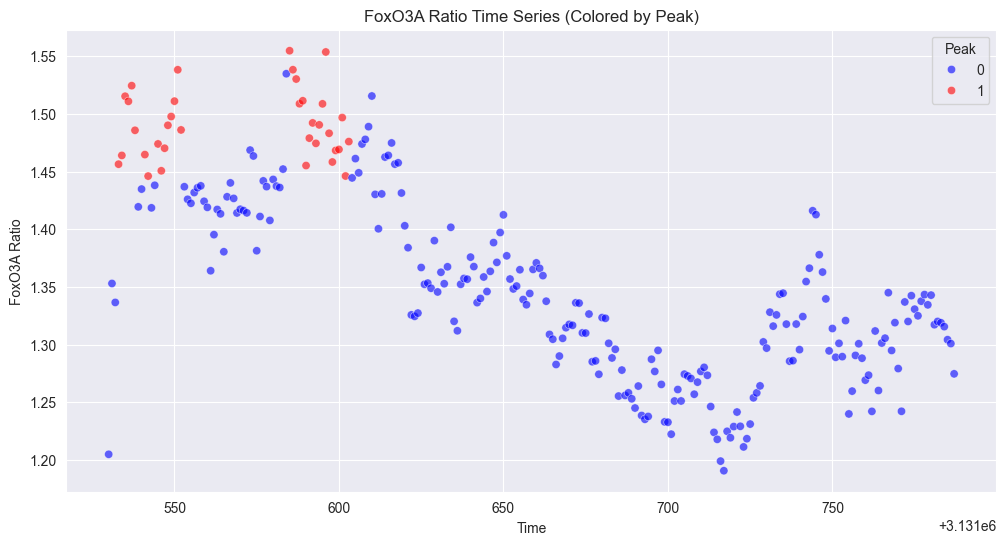

In [8]:
# Check the detected peaks

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=fox_df.index,
    y=fox_df['FoxO3A_ratio'],
    hue=fox_df['active'],
    palette={True: 'red', False: 'blue'},
    alpha=0.6
)
plt.title('FoxO3A Ratio Time Series (Colored by Peak)')
plt.xlabel('Time')
plt.ylabel('FoxO3A Ratio')
plt.legend(title='Peak', loc='upper right')
plt.show()

### Identification of active cells and neighbors

In [7]:
# Data for calculated experiments and only with active cells over time

counted_activity_data = file[
    (file['active'] == True)].copy(deep=True)

In [5]:
radius = 30

# Function to calculating neighbors: all, active, inactive
def count_neighbors(data, radius, col_name):

    grouped = data.groupby(['Image_Metadata_Site','Exp_ID', 'Image_Metadata_T'])

    # Column with nb of neighbors
    data[col_name] = 0
    for (site, expid, time), group in grouped:
        if group.empty:
            continue
        # Cell coordinates for the KDTree
        coords = group[["objNuclei_Location_Center_X", "objNuclei_Location_Center_Y"]].to_numpy()
        # KDTree for a given group (at the same time and location)
        tree = KDTree(coords)

        # Neighbors for a given cell
        neighbors = tree.query_ball_point(coords, r=radius)
        neighbor_counts = [len(n) - 1 for n in neighbors]  # -1, to not include itself
        # Save data in a guven Data frame
        data.loc[group.index, col_name] = neighbor_counts

    return data


In [8]:
# Data with active neighbors in t time for an active cell
counted_activity_data = count_neighbors(counted_activity_data, radius, 'num_active_neighbors')
counted_activity_data.head()

,Exp_ID,Image_Metadata_Site,track_id,Image_Metadata_T,Nuclear_size,ERKKTR_ratio,FoxO3A_ratio,objNuclei_Location_Center_X,objNuclei_Location_Center_Y,Mutation,rolling,above,peak,active,num_active_neighbors
7,1,1,1,7,305.000,1.094710,1.40610,930.784,872.144,wt,1.368556,True,True,1,0
43,1,1,1,43,337.000,1.060400,1.44840,928.475,865.917,wt,1.327033,True,True,1,0
44,1,1,1,44,311.000,0.975023,1.46279,927.887,865.746,wt,1.333133,True,True,1,0
45,1,1,1,45,322.000,0.872370,1.41007,928.401,865.137,wt,1.337837,True,True,1,0
46,1,1,1,46,295.001,0.915782,1.47430,927.044,864.814,wt,1.349479,True,True,1,0


In [27]:
counted_activity_data['num_active_neighbors'].unique()

array([1, 0, 2, 3, 4, 5, 6, 7, 8, 9])

In [36]:
grouped_means = counted_activity_data.groupby(['Image_Metadata_Site','Exp_ID','Image_Metadata_T'])['num_active_neighbors'].mean().reset_index()
grouped_means.head()

,Image_Metadata_Site,Exp_ID,Image_Metadata_T,num_active_neighbors
0,1,1,0,1.323353
1,1,1,1,0.753086
2,1,1,2,0.586466
3,1,1,3,0.604651
4,1,1,4,0.656250


In [38]:
grouped_means['Mutation'] = grouped_means['Image_Metadata_Site'].map(site_to_mutation)
grouped_means.head()

,Image_Metadata_Site,Exp_ID,Image_Metadata_T,num_active_neighbors,Mutation
0,1,1,0,1.323353,wt
1,1,1,1,0.753086,wt
2,1,1,2,0.586466,wt
3,1,1,3,0.604651,wt
4,1,1,4,0.656250,wt


In [29]:
print(grouped_means['num_active_neighbors'].unique())

[1.32335329 0.75308642 0.58646617 ... 0.08510638 0.25581395 0.29126214]


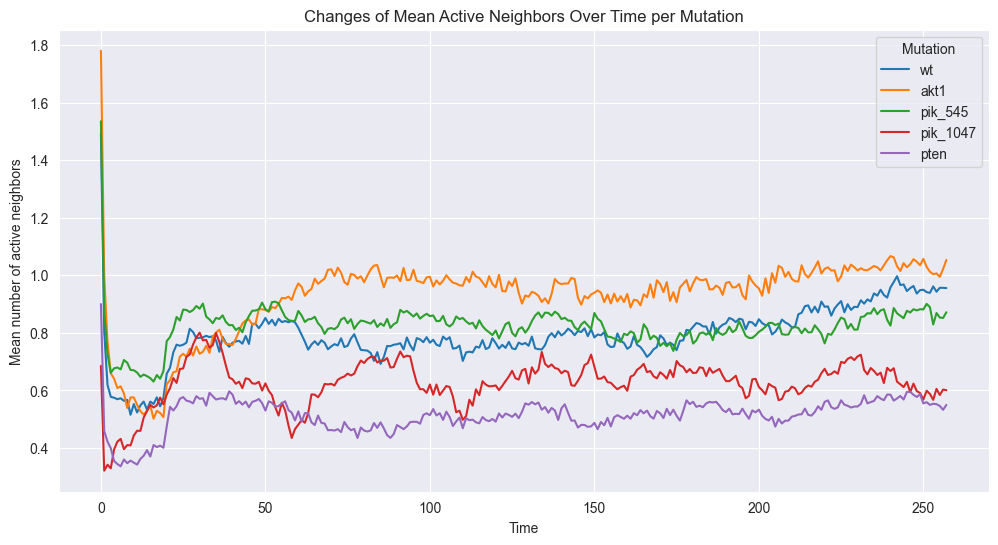

In [83]:
# Plot of mean active neighbors over time for each phenotype

plt.figure(figsize=(12,6))

sns.lineplot(
    data=grouped_means,
    x='Image_Metadata_T',
    y='num_active_neighbors',
    hue='Mutation',
    errorbar=None
)

plt.xlabel('Time')
plt.ylabel('Mean number of active neighbors')
plt.title('Changes of Mean Active Neighbors Over Time per Mutation')
plt.legend(title='Mutation')
plt.show()

### Does the average number of active neighbors depend on the type of mutation?


In [47]:
# Nb of active neighbors for mutation
grouped_mutations = [group['num_active_neighbors'].values for name, group in grouped_means.groupby('Mutation')]

# Kruskal-Wallis test
stat, p_value = kruskal(*grouped_mutations)

# Show results
print(f"Statystyka testu Kruskala-Wallisa: {stat}")
print(f"p-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Istnieją istotne różnice między grupami.")
else:
    print("Brak istotnych różnic między grupami.")


Statystyka testu Kruskala-Wallisa: 10152.013647275011
p-value: 0.0
Istnieją istotne różnice między grupami.


### Spacetime element: Animations of active and inactive cells for each phenotype

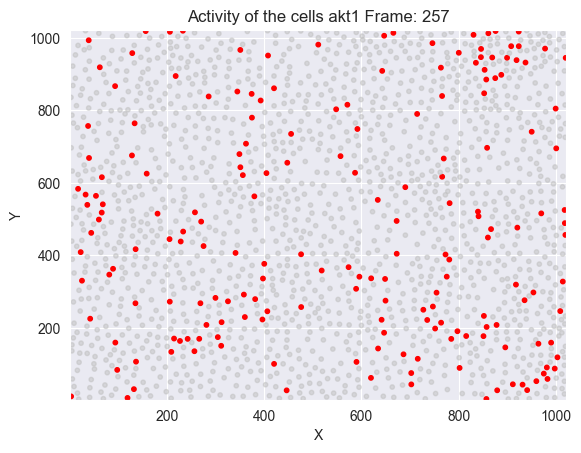

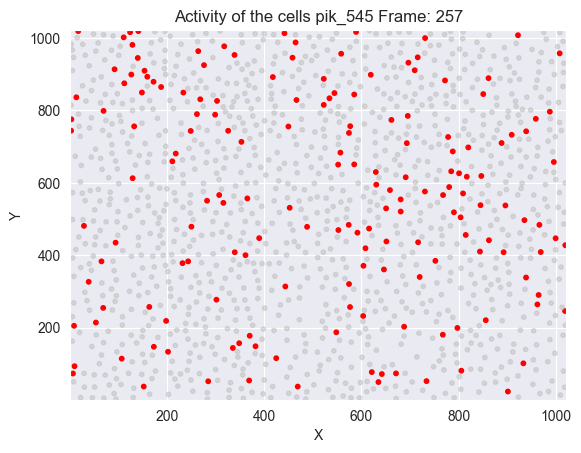

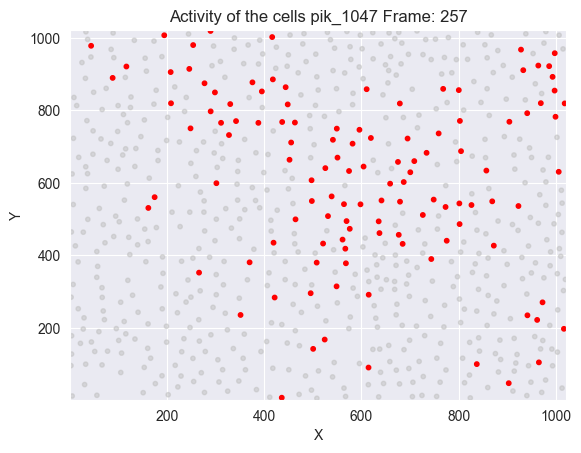

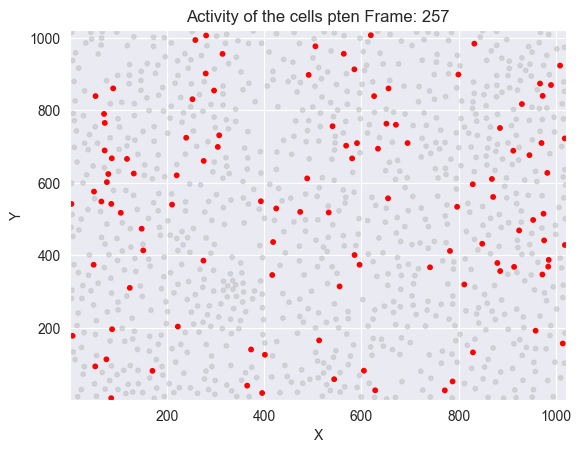

In [11]:
def generate_gif(data, site):

    data_copy = data[(data['Image_Metadata_Site']==site) & (data['Exp_ID']==1) ].copy(deep=True)
    # List of frames
    time_frames = sorted(data_copy['Image_Metadata_T'].unique())

    # Prepare a figure
    fig, ax = plt.subplots()
    sc = ax.scatter([], [], s=10, edgecolor='black')

    # Set axis
    ax.set_xlim(data_copy["objNuclei_Location_Center_X"].min() - 1, data_copy["objNuclei_Location_Center_X"].max() + 1)
    ax.set_ylim(data_copy["objNuclei_Location_Center_Y"].min() - 1, data_copy["objNuclei_Location_Center_Y"].max() + 1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Aktywność komórek w czasie')


    def update(frame):
        # Data for specific time frame
        current_data = data_copy[data_copy['Image_Metadata_T'] == frame]

        # Coordinates of cells
        x = current_data["objNuclei_Location_Center_X"]
        y = current_data["objNuclei_Location_Center_Y"]

        # Colors: grey - inactive, red - active
        colors = current_data['active'].map({1: (1.0, 0.0, 0.0, 1.0), 0: (0.75, 0.75, 0.75, 0.5)})

        # Update a scatter
        sc.set_offsets(list(zip(x, y)))
        sc.set_color(colors)
        ax.set_title(f"Activity of the cells {site_to_mutation[site]} Frame: {frame}")
        return sc,


    # Create animation
    ani = FuncAnimation(fig, update, frames=time_frames, blit=True, interval= 200)  # 500 ms na klatkę
    ani.save(f"C:\\Users\\Anastazja\\Desktop\\animation_{site_to_mutation[site]}.gif", writer=PillowWriter(fps=5))


In [ ]:
generate_gif(file, 1)
generate_gif(file, 5)
generate_gif(file, 9)
generate_gif(file, 13)
generate_gif(file, 19)

## Does the number of neighboring cells at the moment of activation differ between cells with different mutations?

In [9]:
from scipy.spatial import KDTree

radius = 40 # the threshold was increased from 30 to 40 to account for situations where a cell is located within a densely packed group
# count neighbors for a cell in time
file = count_neighbors(file, radius, 'num_neighbors')


In [18]:
print(file['num_neighbors'].unique())

[ 9  8  7  6  5  4  3 10 11  2  1  0 12 13 14 15 16 17 18 19 20]


In [15]:
# find moments of activation

file_sorted = file.sort_values(['Image_Metadata_Site', 'Exp_ID', 'track_id', 'Image_Metadata_T'])

file_sorted['previous_activeness'] = file_sorted.groupby(['Image_Metadata_Site', 'Exp_ID', 'track_id'])['active'].shift(1)
file_sorted['previous_num_neighbors'] = file_sorted.groupby(['Image_Metadata_Site', 'Exp_ID', 'track_id'])['num_neighbors'].shift(1)

activation_event = file_sorted[(file_sorted['previous_activeness'] == 0) & (file_sorted['active'] == 1)].copy()

activation_event.head()

,Exp_ID,Image_Metadata_Site,track_id,Image_Metadata_T,Nuclear_size,ERKKTR_ratio,FoxO3A_ratio,objNuclei_Location_Center_X,objNuclei_Location_Center_Y,Mutation,rolling,above,peak,active,num_neighbors,previous_activeness,previous_num_neighbors
7,1,1,1,7,305.000,1.094710,1.40610,930.784,872.144,wt,1.368556,True,True,1,9,0.0,9.0
43,1,1,1,43,337.000,1.060400,1.44840,928.475,865.917,wt,1.327033,True,True,1,6,0.0,6.0
50,1,1,1,50,306.001,0.821781,1.42149,927.797,863.889,wt,1.380010,True,True,1,7,0.0,7.0
95,1,1,1,95,321.000,0.687643,1.41166,930.732,860.106,wt,1.344472,True,True,1,6,0.0,6.0
97,1,1,1,97,346.000,0.970804,1.41036,929.413,859.685,wt,1.354181,True,True,1,6,0.0,6.0


In [14]:
# Test Kruskala-Wallisa:
# the dependence between nb of neighboring cells and mutation
groups = [group['previous_num_neighbors'].values for name, group in activation_event.groupby('Mutation')]

stat, p_value = kruskal(*groups)

print(f"Statystyka testu: {stat}, p-value: {p_value}")


Statystyka testu: 368434.0333083546, p-value: 0.0


In [15]:
from scikit_posthocs import posthoc_dunn

# Test Dunn'a
dunn_test = posthoc_dunn(activation_event, val_col='previous_num_neighbors', group_col='Mutation')

print(dunn_test)

          akt1  pik_1047  pik_545  pten   wt
akt1       1.0       0.0      0.0   0.0  0.0
pik_1047   0.0       1.0      0.0   0.0  0.0
pik_545    0.0       0.0      1.0   0.0  0.0
pten       0.0       0.0      0.0   1.0  0.0
wt         0.0       0.0      0.0   0.0  1.0


In [13]:
# calculate mean of neighbors for each mutation
# to order the mutations in Spearman correlation
mean_neigh = activation_event.groupby('Mutation')['previous_num_neighbors'].mean().sort_values()
print(mean_neigh)

Mutation
pik_1047    2.671033
pten        3.712301
wt          5.379185
pik_545     5.773911
akt1        7.147547
Name: previous_num_neighbors, dtype: float64


In [16]:
# Spearman correlation
mutation_order = {'pik_1047': 0, 'pten': 1, 'wt': 2, 'pik_545': 3, 'akt1':4}  # przykład
activation_event['Mutation_code'] = activation_event['Mutation'].map(mutation_order)

corr_coef, p_value = spearmanr(activation_event['Mutation_code'], activation_event['previous_num_neighbors'])

print(f"Korelacja Spearmana: {corr_coef}, p-value: {p_value}")

Korelacja Spearmana: 0.6053272269111518, p-value: 0.0


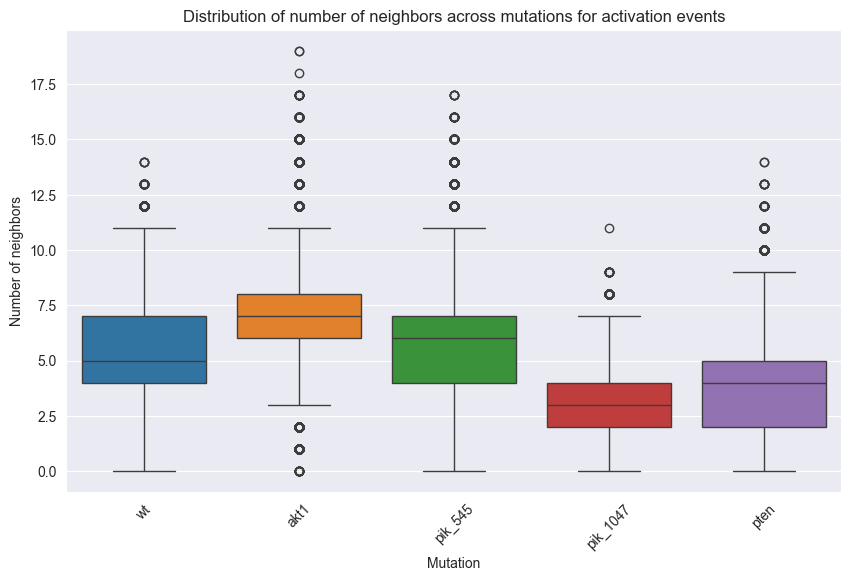

In [17]:
# Boxplot of nb of neighbors for each phenotype for activation events

plt.figure(figsize=(10,6))
sns.boxplot(data=activation_event, x='Mutation', y='previous_num_neighbors', hue='Mutation')
plt.title('Distribution of number of neighbors across mutations for activation events')
plt.xlabel('Mutation')
plt.ylabel('Number of neighbors')
plt.xticks(rotation=45)
plt.show()